# Linear regression model for the sale price of homes¶

## Purpose

## Assumptions

## Issues

## Analysis Method

## Conclusion

In [35]:
import sqlalchemy
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

Load all the [data](https://info.kingcounty.gov/assessor/DataDownload/default.aspx) from three tables:
- Real Property Sales 
- Residential Building 
- Parcel 


### Create POSTGRES SQL engine and query from housing_prices database.

In [3]:
engine = create_engine("postgresql:///housing_prices")

In [4]:
sql = 'sql/join_table.sql'
scriptFile = open(sql,'r')
script = scriptFile.read()
df = pd.read_sql(sqlalchemy.text(script), con = engine)

In [37]:
df['open_plus_closed_porch']= df['sqftenclosedporch'] + df['sqftopenporch']

Calculate the age of the house.

In [39]:
df['age'] = 2019 - df['yrbuilt']

### Export table to csv file.

In [485]:
# df.to_csv(r'../data/processed/residential.csv')

### Use OneHotEncoder to encode categorical features as a one-hot numeric array.

In [33]:
def ohe_func(feature, df):
    
    """
    Encode int categorical features as a one-hot numeric array 
    return df which include new numeric column and original df

    """
    
    df_feature = df[[feature]]
    onehotencoder = OneHotEncoder(categorical_features = [0])
    data_str_ohe=onehotencoder.fit_transform(df_feature).toarray()
    df_new = pd.DataFrame(data_str_ohe)
    df = pd.concat([df, df_new],axis=1)
    
    return df

Put the categorical features to ohe_func function to get one-hot numeric and rename columns.

In [ ]:
df = ohe_func('wfntlocation', df)
df.rename(columns={0:"wfntlocation_0", 1:"wfntlocation_3", 2:"wfntlocation_6", 3:"wfntlocation_7", 4:"wfntlocation_8", 5:"wfntlocation_9"}, inplace=True)

Encode string categorical features as a one-hot numeric array

In [13]:
df_feature = df['directionprefix']
df_dir = pd.DataFrame(df_feature)
ohe = OneHotEncoder(drop='first')
df_dir.fillna("D",inplace=True)
df_dir_trans = ohe.fit_transform(df_dir)
df_dir_trans.todense()
df_dir = pd.DataFrame(df_dir_trans.todense(), columns=ohe.get_feature_names())
df_dir.rename(columns={df_dir.columns[0]:"directionprefix_E", 
                       df_dir.columns[1]:"directionprefix_N", 
                       df_dir.columns[2]:"directionprefix_NE", 
                       df_dir.columns[3]:"directionprefix_NW", 
                       df_dir.columns[4]:"directionprefix_S",
                       df_dir.columns[5]:"directionprefix_SE",
                       df_dir.columns[6]:"directionprefix_SW",
                       df_dir.columns[7]:"directionprefix_W",}, 
              inplace=True)
df = pd.concat([df, df_dir],axis=1)

In [23]:
preds = df[['sqfttotliving','sqftopenporch']]
# preds = df[['sqfttotliving','sqftopenporch', 'trafficnoise']]
target = df['saleprice']

## Can we model square foot of living with price?
Create a model with one predictor, for practice.

In [40]:
df_reduced0 = df[['sqfttotliving']]
X = df_reduced0
Y = df['saleprice']
X_scaled = (X - np.mean(X)) / np.std(X)
predictors = sm.add_constant(X_scaled)
predictors = sm.add_constant(X)
model = sm.OLS(np.asarray(Y), predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     1440.
Date:                Wed, 04 Dec 2019   Prob (F-statistic):          3.18e-279
Time:                        18:01:08   Log-Likelihood:                -79881.
No. Observations:                5339   AIC:                         1.598e+05
Df Residuals:                    5337   BIC:                         1.598e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.703e+04   2.28e+04      1.184      0.237   -1.77e+04    7.18e+04
sqfttotliving   377.3949      9.944     37.950      0.000     357.900     396.890
==============================================================================
Omnibus:                     9563.679   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20014205.191
Skew:                          12.660   Prob(JB):                         0.00
Kurtosis:                     301.877   Cond. No.                     5.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

TypeError: unsupported operand type(s) for *: 'type' and 'float'

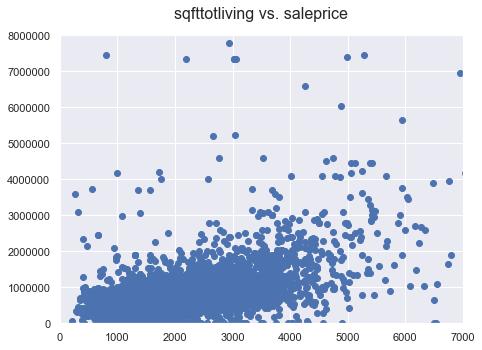

In [41]:
fig = plt.figure(figsize=(7, 5))
fig.suptitle('sqfttotliving vs. saleprice', fontsize=16)
axes= fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.set_xlim([0,7000])
axes.set_ylim([0,8000000])
plt.scatter(df['sqfttotliving'], df['saleprice'])
llist = range(10000)
plt.plot(llist, model.params[0]+list*model.params[1], c='black')
plt.xlabel('sqrtfttotliving', fontsize=14)
plt.ylabel('saleprice', fontsize=14)
plt.show()

Plot error histogram.

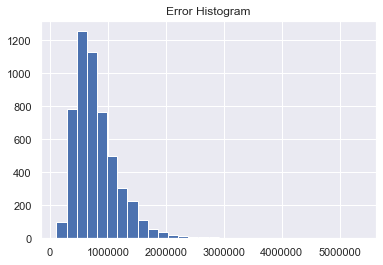

In [42]:
plt.title("Error Histogram")
plt.hist(model.fittedvalues, bins=30);

In [24]:
preds_scaled = (preds - np.mean(preds)) / np.std(preds)
predictors = sm.add_constant(preds_scaled)
model = sm.OLS(target, predictors).fit()
model.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     730.9
Date:                Wed, 04 Dec 2019   Prob (F-statistic):          2.83e-281
Time:                        17:19:04   Log-Likelihood:                -79872.
No. Observations:                5339   AIC:                         1.598e+05
Df Residuals:                    5336   BIC:                         1.598e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7.979e+05   1.04e+04     76.676      0.000    7.77e+05    8.18e+05
sqfttotliving  3.754e+05   1.15e+04     32.718      0.000    3.53e+05    3.98e+05
sqftopenporch  4.759e+04   1.15e+04      4.147      0.000    2.51e+04    7.01e+04
==============================================================================
Omnibus:                     9596.659   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         20613317.331
Skew:                          12.747   Prob(JB):                         0.00
Kurtosis:                     306.334   Cond. No.                         1.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

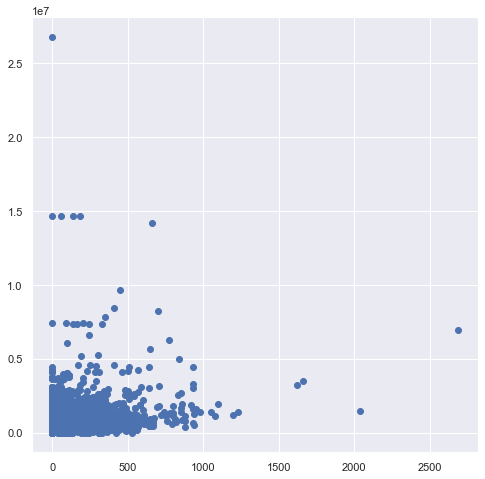

In [25]:
plt.scatter(preds['sqftopenporch'], target)

In [30]:
X = df[['sqfttotliving','open_plus_closed_porch','wfntfootage']]
Y = df['saleprice']
# yrhouse 0.05

In [31]:
X_scaled = (X - np.mean(X)) / np.std(X)
predictors = sm.add_constant(X_scaled)
predictors = sm.add_constant(X)
model = sm.OLS(np.asarray(Y), predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     542.0
Date:                Wed, 04 Dec 2019   Prob (F-statistic):          1.75e-307
Time:                        17:22:00   Log-Likelihood:                -79808.
No. Observations:                5339   AIC:                         1.596e+05
Df Residuals:                    5335   BIC:                         1.597e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    3.22e+04   2.27e+04      1.421      0.155   -1.22e+04    7.66e+04
sqfttotliving            357.4465     10.700     33.407      0.000     336.471     378.423
open_plus_closed_porch   225.6785     73.491      3.071      0.002      81.606     369.751
wfntfootage             5391.3048    462.519     11.656      0.000    4484.579    6298.030
==============================================================================
Omnibus:                     9354.657   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17991705.457
Skew:                          12.078   Prob(JB):                         0.00
Kurtosis:                     286.361   Cond. No.                     5.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""